# Polarization week 2
`Dopo aver classificato, per la settimana di interesse, utenti influenti e non, si procede con il calcolo della polarizzazione`

In [1]:
import numpy as np
import itertools
import collections
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix

In [2]:
import sys
sys.path.append('../')

In [3]:
from lib import mongoAPI

## Read dataframe (da MongoDB)
Si ottengono tutte le interazioni (retweet) tra un utente influente (chiamato anche "Page") e un utente non influente ("User")

In [4]:
print("Connessione MongoDB...")
mongo_conn = mongoAPI.get_connection("localhost", 27027)
mongo_db = mongo_conn.get_db("dataman_project")
mongo_coll_links = mongo_db.get_collection("links")
print("Done")

Connessione MongoDB...
Done


In [5]:
week = 2
df = mongo_coll_links.read_df_week(week)
del df["week"]
df.head()

,page,user
0,2812961,1150021570221547520
1,2812961,398811891
2,2812961,440129638
3,2812961,1961241529
4,2812961,793367160341094400


## Map users ID and pages ID to sequence (1,len(users))
Anziché gli ID utilizzati da Twitter, si associano, a pagine e utenti, un ID progressivo

In [6]:
mapping_pages = {user:index for index, user in enumerate(set(df["page"]))}
mapping_users = {page:index for index, page in enumerate(set(df["user"]))}
rev_dict_pages = {value:key for key,value in mapping_pages.items()}
rev_dict_users = {value:key for key,value in mapping_users.items()}

In [7]:
df_ = pd.DataFrame()
df_["page"] = df["page"].replace(mapping_pages)
df_["user"] = df["user"].replace(mapping_users)

## Visualizzazione grafo bipartito utenti - pagine

In [8]:
indexes = df_[["user", "page"]].to_numpy()
indexes

array([[12965,  1308],
       [30745,  1308],
       [41106,  1308],
       ...,
       [31163,  1987],
       [21592,  1904],
       [11760,  1904]])

## Costruzione matrice di proiezione (V,E)
#### V = Pagine
#### E = archi pesati con numeri di utenti condivisi tra le pagine

### 1- Creo dizionario:
* key = id utente
* value = lista pagine con cui ha interagito

In [9]:
user_pages_dict = collections.defaultdict(list)
for tuple_ in indexes:
    if tuple_[1] not in user_pages_dict[tuple_[0]]:
        user_pages_dict[tuple_[0]].append(tuple_[1])

#user_pages_dict

### 2- Lista di tuple:
Se un utente ha interagito con più di una pagina, allora tali pagine "condividono" quello stesso utente.

Genero tutte le permutazioni di 2 elementi estratti dalle pagine (la matrice di proiezione deve essere simmetrica).

In altri termini ogni volta che due pagine A e B condividono un utente genero tupla (A,B), che rappresenta un arco del grafo di proiezione

In [10]:
edges = [pages_index_pair for pages_index in user_pages_dict.values() if len(pages_index) > 1 for pages_index_pair in list(itertools.permutations(pages_index, 2))]
#edges

### 3- Pesi:
Contando le tuple ottengo il numero di utenti che la coppia (A,B) condivide, i.e. il peso dell'arco del grafo di proiezione

In [11]:
edges_weights = collections.Counter(edges)
edges_weights

Counter({(1308, 2469): 23,
         (1308, 1877): 41,
         (1308, 1): 132,
         (1308, 439): 49,
         (1308, 2953): 28,
         (1308, 896): 99,
         (1308, 2139): 29,
         (1308, 1693): 9,
         (1308, 3341): 8,
         (1308, 2685): 8,
         (1308, 3104): 11,
         (1308, 1423): 2,
         (1308, 126): 28,
         (1308, 156): 20,
         (1308, 2513): 13,
         (1308, 1738): 77,
         (1308, 3045): 46,
         (1308, 1298): 15,
         (1308, 1522): 14,
         (1308, 1506): 35,
         (1308, 571): 11,
         (1308, 3296): 25,
         (1308, 1475): 9,
         (2469, 1308): 23,
         (2469, 1877): 33,
         (2469, 1): 78,
         (2469, 439): 32,
         (2469, 2953): 18,
         (2469, 896): 41,
         (2469, 2139): 21,
         (2469, 1693): 8,
         (2469, 3341): 5,
         (2469, 2685): 3,
         (2469, 3104): 7,
         (2469, 1423): 1,
         (2469, 126): 8,
         (2469, 156): 9,
         (2469, 2513): 13,


### 4- Matrice di proiezione:
Tenendo conto del volume, memorizzo la matrice in una matrice sparsa, cioè salvo solo gli archi effettivamente presenti, escludendo quelli con peso zero.
Ciò è possibile utilizzando matrici sparse di SciPy

In [12]:
def dict_to_sparse_matrix(dict_graph):
    data = np.array(list(dict_graph.values()))
    A = np.array(list(dict_graph.keys()))
    rows = A.T[1]
    cols = A.T[0]
    B = coo_matrix((data, (rows, cols)), shape=(len(mapping_pages), len(mapping_pages)))
    return csr_matrix(B)

In [13]:
P = dict_to_sparse_matrix(edges_weights)


## Community detection

### Si considerano due algoritmi di Community detection:
* Louvain Algorithm
* Label Propagation

In [14]:
from sknetwork.clustering import Louvain, PropagationClustering, modularity 

## Louvain

In [15]:
louvain = Louvain(modularity="dugue")
labels_louvain = louvain.fit_transform(P)

### Valutazione misura di modularità
Si valuta la bontà del clustering attraverso misura di modularità.
SPIEGAZIONE: range valori ecc..

In [16]:
modularity(P, labels_louvain, return_all=True)

(0.3658993167373882, 0.9074492144932494, 0.5415498977558613)

### Dimensione clusters

In [17]:
collections.Counter(labels_louvain)

Counter({1: 1227,
         0: 2185,
         2: 9,
         5: 2,
         12: 1,
         55: 1,
         54: 1,
         53: 1,
         52: 1,
         51: 1,
         50: 1,
         56: 1,
         49: 1,
         4: 2,
         47: 1,
         46: 1,
         45: 1,
         44: 1,
         43: 1,
         42: 1,
         48: 1,
         57: 1,
         58: 1,
         59: 1,
         74: 1,
         73: 1,
         72: 1,
         71: 1,
         3: 4,
         70: 1,
         69: 1,
         68: 1,
         67: 1,
         66: 1,
         65: 1,
         64: 1,
         63: 1,
         62: 1,
         61: 1,
         60: 1,
         40: 1,
         75: 1,
         39: 1,
         22: 1,
         18: 1,
         17: 1,
         16: 1,
         15: 1,
         14: 1,
         20: 1,
         19: 1,
         11: 1,
         10: 1,
         9: 1,
         8: 1,
         7: 1,
         13: 1,
         6: 2,
         38: 1,
         21: 1,
         37: 1,
         36: 1,
         35:

### Commento:
* Buon valore di modularità
* 2 grandi clusters

## Label Propagation

In [18]:
propagation = PropagationClustering(sort_clusters=True)
labels_propagation = propagation.fit_transform(P)

### Valutazione misura di modularità

In [19]:
modularity(P, labels_propagation, return_all=True)

(0.35827290177713556, 0.9166142456697114, 0.5583413438925758)

### Dimensione clusters

In [20]:
collections.Counter(labels_propagation)

Counter({16: 1403,
         25: 2024,
         0: 1,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 2,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         64: 2,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 1,
         61:

### Commento:
* Modularità buona
* 2 grandi cluster

### Osservazioni:
* Dubbio su quale algoritmo scegliere

In [21]:
check = pd.DataFrame({"Louv" : labels_louvain, "Prop" : labels_propagation})
check.head()

,Louv,Prop
0,1,16
1,0,25
2,1,16
3,0,25
4,1,16


In [64]:
labels_propagation_adj = np.where(labels_propagation == 16, 1, labels_propagation)
labels_propagation_adj = np.where(labels_propagation_adj == 25, 0, labels_propagation_adj)
labels_propagation_adj

array([1, 0, 1, ..., 1, 0, 0])

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(labels_propagation_adj, labels_louvain)

0.926021136818052

### Osservazioni:
* I due algoritmi producono risultati estremamente simili
* Si sceglie quindi quello con modularità migliore (Louvain) anche se lo scarto è minimo

## Validazione manuale (quale cluster è vax e quale non)
Non avendo dati disponibili per una validazione supervisionata si procede manualmente:
Per ogni cluster si estrae un campione di utenti, e studiandone il feed, si decide se essi siano pro-vax, no-vax o neutrali

### Verifichiamo chi sono alcuni di loro con le API di Twitter

In [25]:
import tweepy
#Configurazione e autenticazione
access_token = "1328983562767519750-dF4HK59zfJrtqmnziHoM7eMHuQZN2F"  
access_token_secret = "NwYbWnA5rnxkxQISCuvxRk3wG5YVqwstp3w6Uz4uCp8H2"  
consumer_key = "y3TqPO1ZOOajzhX7Fh0tpc59M"  
consumer_secret = "ll4t1rp3rrHvsYtzONUhpKemaqFtVWWmEQKOODasdyJwajiUsx"  

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

_____________________________________________________________________________________________________________________________________

### Cluster 0

_____________________________________________________________________________________________________________________________________

In [26]:
print(rev_dict_pages[1], labels_louvain[1])

732817452569141248 0


In [27]:
print(api.get_user(732817452569141248).screen_name)

RobertoBurioni


NB. dalla presenza di Burioni nel cluster 0 si può intuire che si tratti di quello dei Pro vax

***

In [28]:
print(rev_dict_pages[811], labels_louvain[811])

438339383 0


In [67]:
print(api.get_user(438339383).screen_name)

LucaBellinzona


pro vax

_____________________________________________________________________________________________________________________________________

In [69]:
print(rev_dict_pages[24], labels_louvain[24])

973373467 0


In [31]:
print(api.get_user(973373467).screen_name)

l_angiolini


pro vax

***

In [32]:
print(rev_dict_pages[947], labels_louvain[947])

473958561 0


In [71]:
print(api.get_user(473958561).screen_name)

Dario_Donato


pro vax

_____________________________________________________________________________________________________________________________________

### Cluster 1

***


In [73]:
print(rev_dict_pages[947], labels_louvain[947])

473958561 0


In [35]:
print(api.get_user(475234937 ).screen_name)

valy_s


no vax

***


In [75]:
print(rev_dict_pages[285], labels_louvain[285])

475234937 1


In [37]:
print(api.get_user(475234937 ).screen_name)

valy_s


no vax

_____________________________________________________________________

In [77]:
print(rev_dict_pages[1744], labels_louvain[1744])

1085912953466048512 0


In [39]:
print( api.get_user(1085912953466048512).screen_name)

RisatoNicola


no vax

______________________________________________

In [79]:
print(rev_dict_pages[1942], labels_louvain[1942])

1035376896 1


In [41]:
print(api.get_user(1035376896).screen_name)

MamolkcsMamol


no vax

______________________________________________

## Osservazioni:
* 1 -> novax
* 0 -> provax

# Polarizzazione
## Distribuzione vax - novax
Si sceglie il clustering prodotto da Algoritmo Louvain

In [42]:
page_community_df = pd.DataFrame({"page_id" : rev_dict_pages.values(), "community" : labels_louvain})
page_community_df.head()

,page_id,community
0,1024702799215509504,1
1,732817452569141248,0
2,1275091375474835456,1
3,1182665278917885955,0
4,1248609816576065539,1


## Conservo solo le pagine dei due cluster principali

In [43]:
page_community_df = page_community_df[(page_community_df["community"] == 0) | (page_community_df["community"] == 1)]
page_community_df.head()

,page_id,community
0,1024702799215509504,1
1,732817452569141248,0
2,1275091375474835456,1
3,1182665278917885955,0
4,1248609816576065539,1


## Conto, per ciascun utente, numero di interazioni con ciascuna community

In [44]:
result = pd.merge(df, page_community_df, how="inner", left_on="page", right_on = "page_id")
result.head()

,page,user,page_id,community
0,2812961,1150021570221547520,2812961,0
1,2812961,398811891,2812961,0
2,2812961,440129638,2812961,0
3,2812961,1961241529,2812961,0
4,2812961,793367160341094400,2812961,0


In [45]:
count_interact_community  = result.groupby(["user", "community"]).count().sort_values("page").reset_index()
count_interact_community

,user,community,page,page_id
0,1393850778889109508,0,1,1
1,2334062219,1,1,1
2,2333859956,0,1,1
3,2333786184,0,1,1
4,2333745212,1,1,1
...,...,...,...,...
48091,2252899982,1,286,286
48092,4160203479,1,352,352
48093,742397759991480320,1,396,396
48094,971816547898490881,1,463,463


Si osserva che molti utenti interagiscono con entrambe le community, per cui la polarizzazione non è immediata:

In [46]:
tmp = count_interact_community.groupby("user").count().reset_index()
tmp[tmp["community"] >= 2][["user", "community"]]

,user,community
31,821343,2
69,6012422,2
92,7068032,2
103,7785632,2
130,8960282,2
...,...,...
44349,1369753673463705605,2
44396,1370333152573583361,2
44405,1370395858513068037,2
44408,1370450512483643402,2


In [47]:
del tmp

Ad es. l'utente seguente:

In [48]:
result[result["user"] == 8960282]

,page,user,page_id,community
24985,70971449,8960282,70971449,0
55337,51759517,8960282,51759517,1
80972,763485613,8960282,763485613,1
94130,104170025,8960282,104170025,1
94442,104170025,8960282,104170025,1
123904,1063628538,8960282,1063628538,1
142652,504631659,8960282,504631659,0
145555,2719470235,8960282,2719470235,1
145566,2719470235,8960282,2719470235,1
145569,2719470235,8960282,2719470235,1


In [49]:
count_interact_community_pivot = count_interact_community.pivot(index = "user", columns="community", values = "page")
count_interact_community_pivot.fillna(0, inplace = True)
count_interact_community_pivot

community,0,1
user,,
3637,12.0,0.0
22873,1.0,0.0
45763,2.0,0.0
286543,1.0,0.0
380913,1.0,0.0
...,...,...
1385509486270599168,0.0,1.0
1385657754220650498,1.0,0.0
1386297698337308676,2.0,0.0


## Si considerano solo utenti con almeno 10 interazioni

In [50]:
count_interact_community_pivot = count_interact_community_pivot[count_interact_community_pivot[0] + count_interact_community_pivot[1] > 10]
count_interact_community_pivot

community,0,1
user,,
3637,12.0,0.0
742783,31.0,0.0
821343,2.0,19.0
2002721,20.0,0.0
5718002,0.0,16.0
...,...,...
1369638806534713344,12.0,0.0
1369753673463705605,4.0,26.0
1369989958736437249,27.0,0.0


# Costruzione della PDF

In [51]:
def polarization(pos, neg):
    return (pos-neg)/(pos+neg)

In [52]:
def polarization_neutral(pos,neg,neut):
    N = pos+neg+neut
    a = (pos-neg)/(pos+neg)
    return a - a*neut/N

In [53]:
data = polarization(count_interact_community_pivot[0], count_interact_community_pivot[1]).to_numpy()
data

array([ 1.        ,  1.        , -0.80952381, ...,  1.        ,
        0.81818182, -1.        ])

## Kernel Density Estimation

In [54]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

kde = gaussian_kde(data)
dist_space = linspace(min(data), max(data), 100)
x = kde(dist_space)
peaks, _ = find_peaks(x, distance=50)

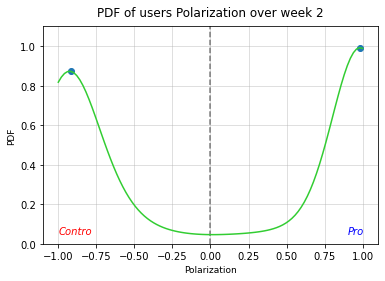

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f"PDF of users Polarization over week {week}", pad = 10)
ax.grid(alpha = 0.5)
ax.axvline(0, color = "black", linestyle='--', alpha = 0.5)
ax.plot(dist_space[peaks], x[peaks], "o")
ax.plot(dist_space, x, color = "limegreen")
ax.set_xlabel('Polarization', fontsize=9)
ax.set_ylabel('PDF', fontsize=9)
ax.set_ylim(0,1.1)
ax.text(0.9, 0.05, 'Pro', style='italic', color = "b")
ax.text(-1, 0.05, 'Contro', style='italic', color = "r")
plt.show()

## Osservazioni:
* Distribuzione bimodale

(array([ 940.,  383.,  108.,   98.,   57.,   35.,   21.,   24.,    8.,
          13.,   19.,   19.,   11.,   20.,   22.,   27.,   52.,   29.,
         116., 1428.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

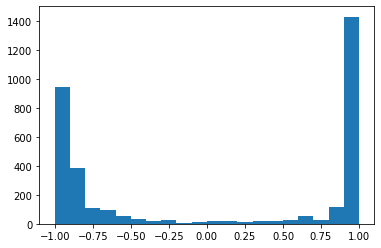

In [56]:
plt.hist(data, bins = 20)

## Osservazioni:
* Distribuzione bimodale

## Test statistico di bimodalità (Dip Test)
H_0 : Distribuzione unimodale

In [57]:
import unidip.dip as dip

data = np.msort(data)
test = dip.diptst(data)
print(test) #dip, pvalue, indices

(0.19110787172011662, 0.000999000999000999, (419, 503))


Si rifiuta ipotesi nulla di unimodalità con confidenza del 1 %

## Bimodality Coeff

In [58]:
from scipy.stats import kurtosis, skew
def bimodality_coeff(distr):
    g = skew(distr)
    k = kurtosis(distr)
    n = len(distr)
    return (g**2 + 1) / (k + 3*(n-1)**2/((n-2)*(n-3)))

In [59]:
density = kde(dist_space)
bc = bimodality_coeff(data)
bc

0.9165555667646723

In [60]:
def bimodality_ratio(a,b):
    return a/b if a < b else b/a

In [61]:
bimodal_ratio = bimodality_ratio(*list(x[peaks]))
bimodal_ratio

0.8791315827701216

In [62]:
bc*bimodal_ratio

0.8057729461065922

In [63]:
import pickle

with open("polarization.pickle", "ab") as file:
    pickle.dump({"week" : week, "bimodality_coeff" : bc, "bimodality_ratio" : bimodal_ratio, "dip_stat" : test[0]}, file)